# Ziegler-Nichols PID tuner


The Ziegler-Nichols mmethod for PID tuner consists of two methodologies to find constant values in a P, PI or PID controller.

## First methodology
In the first methodology, the controller block has the form:
$$
	G_c(s)=K_p\left(1+\frac{1}{\tau_is}+\tau_ds\right)
$$
The aim in this methodology is to find $K_p$, $\tau_d$ and $\tau_i$. For this we use the table<br />
<p align="center">
<img width="300" src=./tabla2.png>
</p>
Where $\tau$, $K$ and $L$ can be found as in the next picture<br />
<p align="center">
<img width="300" src=./met1.png>
</p>
Where $c(t)$ is the open loop system response to a unit impulse.<br /><br />

## Second methodology
In the second methodology, we set a proportional critic value $K_{cr}$ where the system presents a sustained oscillatory behavior. This is a try and error step. Once $K_{cr}$ is found we calculate the period $P_{cr}$.<br />
<p align="center">
<img width="500" src=./osc.png>
</p>
Tuning is done according to the netx table<br />
<p align="center">
<img width="550" src=./tabla3.png>
</p>
In this case the controller is defined as
$$
\begin{split}
	G_c(s)&=K_p\left(1+\frac{1}{\tau_is}+\tau_ds\right)\\
	&=0.6K_{cr}\left(1+\frac{1}{0.5P_{cr}s}+0.125P_{cr}s\right)\\
	&=0.075K_{cr}P_{cr}\frac{\left(s+\frac{4}{P_{cr}}\right)^2}{s}
	\end{split}
$$
If the system does not present sustained oscillations, this methodology is not useful.<br /><br />

We present a PID tuning for the following system using both of these methodologies
<p align="center">
<img width="600" src=./sys.png>
</p>

In [1]:
import numpy as np
import control as ctr
import matplotlib.pyplot as plt

In [2]:
## Aproximación de una derivada
def derivative(f, tk, tk_1, delta_t):
    return (f(tk) - f(tk_1))/delta_t

In [3]:
## Solución de ecuaciones diferenciales usando el método de Euler
def euler(f, der, t_0, delta_t, Time):
    K = int((Time[1]-Time[0])/delta_t)
    
    t = np.zeros(K)
    y = np.zeros(K)
    t[0] = t_0
    y[0] = f(t_0)
    for i in range (1,K):
        t[i] = t[i-1] + delta_t*der(f, t[i], t[i-1], delta_t)
        y[i] = f(t[i])
        
    return t,y

In [4]:
## función del error
def error(Y, R):
    return Y-R

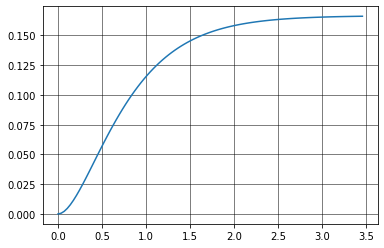

In [5]:
## Funcion de transferencia en lazo abierto sin PID
num = np.array([0., 0., 1.])
den = np.array([1., 5., 6.])

sys = ctr.TransferFunction(num,den)
T, yout = ctr.step_response(sys)
plt.plot(T,yout)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.show()

In [6]:
## Funcion del bloque pid
def PID(kp, ki, kd, ek, sum_e, de, delta_t):
    up = kp * ek
    ui = ki * sum_e
    ud = kd * de
    
    return up + ui + ud

In [7]:
## Bloques G(s) y H(s) en el dominio temporal
def g_t(t):
    return np.exp(-2*t) - np.exp(-3*t)

def h_t(t):
    return np.exp(-4*t)

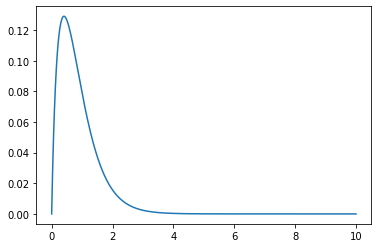

In [9]:
## Sistema 

# Se define el tiempo en el que el sistema funcionará
delta_t = 0.01
t_0 = 0.
t_end = 10.
n = int((t_end - t_0)/delta_t)

t = np.linspace(t_0, t_end, n)

# vector de salida
c_t = np.zeros(n)

# valor de las constantes en el controlador PID
kp = 1.
tau_i = 0
tau_d = 0
ki = 0#kp/tau_i
kd = 0#kp*tau_d

# Se establece el valor de referencia
r_t = 1.       # escalón unitario

# Se calculan de forma iterativa los valores de c_t
for k in range(1,n):
    t_k = t_0 + k*delta_t
    
    if k == 1:
        ek = r_t
        sum_e = 0
        de = 0
        
        u = PID(kp, ki, kd, ek, sum_e, de, delta_t)
        c_t[k] = u * g_t(t_k)
        
    else:
        ek = r_t - c_t[k-1]#*h_t(t_k)
        sum_e += ek*delta_t
        de = (ek - ek_1)/delta_t
        
        
        u = PID(kp, ki, kd, ek, sum_e, de, delta_t)
        c_t[k] = u * g_t(t_k)
        
    ek_1 = ek

#print(c_t)


    
# Se mestran los resultados en una gráfica
plt.plot(t,c_t)
#plt.plot(t,h_t(t))
plt.show()

[0.0, 0.6749999999999999, 14.562917398945517, 99.57345078622811, 208.48712476178414]
[1.0, 9.0, 26.675, 35.86291739894552, 52.121781190446036]


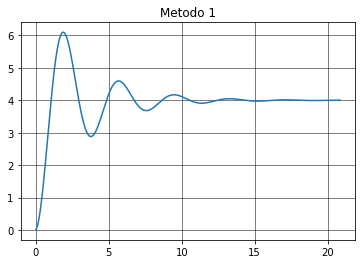

In [10]:
### Método 1 PID
## Sistema en lazo abierto usando librería de control

# Se establecen los valores K, L y tau
K = 1/6
L = 0.1138
tau = 1.125

# Se encuentran los valores K_p, tau_i, tau_d
Kp = 1.2*(tau/L)
tau_i = 2*L
tau_d = 0.5*L
#print(Kp, tau_i, tau_d)

# Se encuentran los valores para K_i y K_d
Ki = Kp/tau_i
Kd = Kp*tau_d
#print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]
print(num)
print(den)

sys1 = ctr.TransferFunction(num,den)
t, c_t = ctr.step_response(sys1)

plt.plot(t,c_t)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Metodo 1')
plt.show()

210.0 0.2276 0.0569


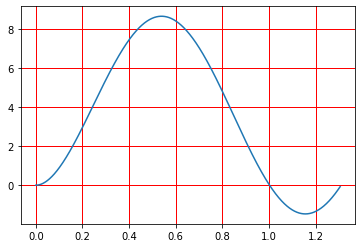

In [19]:
### Método 2 PID
# Encontrar Kp tal que el sistema oscila

# Se establecen los valores K, L y tau
K = 1/6
L = 0.1138
tau = 1.125

# Se encuentran los valores K_p, tau_i, tau_d
Kp = 210.#1.2*(tau/L)
tau_i = 2*L
tau_d = 0.5*L
print(Kp, tau_i, tau_d)

# Se encuentran los valores para K_i y K_d
Ki = 0.#Kp/tau_i
Kd = 0.#Kp*tau_d
#print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]

sys = ctr.TransferFunction(num,den)
T = np.linspace(0,1.305,1000)
t, c_t = ctr.step_response(sys,T)

plt.plot(t,c_t)
plt.grid(color='r', linestyle='-', linewidth=1)
plt.show()

126.0 193.10344827586206 20.553749999999997
[0.0, 20.553749999999997, 208.21499999999997, 697.1034482758621, 772.4137931034483]
[1.0, 9.0, 46.553749999999994, 150.0, 193.10344827586206]


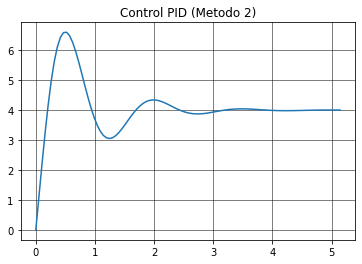

In [14]:
### Método 2 PID
# Aplicacion del PID

# Se establecen los valores Kcr, 
Kcr = 210
Pcr = 1.305

# Se encuentran los valores K_p, tau_i, tau_d
Kp = 0.6*Kcr
tau_i = 0.5*Pcr
tau_d = 0.125*Pcr
#print(Kp, tau_i, tau_d)

# Se encuentran los valores para K_i y K_d
Ki = Kp/tau_i
Kd = Kp*tau_d
print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]
print(num)
print(den)

sys2 = ctr.TransferFunction(num,den)
#T = np.linspace(0,1.305,1000)
t, c_t = ctr.step_response(sys2)

plt.plot(t,c_t)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Control PID (Metodo 2)')
plt.show()

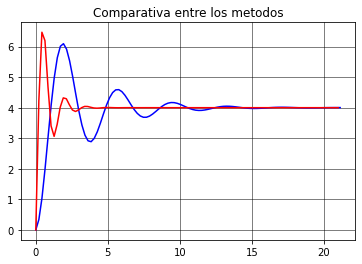

In [11]:
### Se imprimen ambas gr'aficas juntas para su comparativa 
T = np.linspace(0.,21.,100)
t1, c_t1 = ctr.step_response(sys1)
t2, c_t2 = ctr.step_response(sys2,T)

plt.plot(t1,c_t1,color='b')
plt.plot(t2,c_t2,color='r')
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Comparativa entre los metodos')
plt.show()

105.0 0.6525 0
105.0 0 0.0


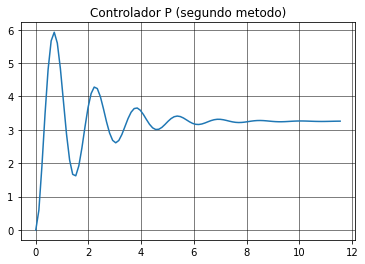

In [12]:
### Control P metodo 2
# Se establecen los valores Kcr, Pcr
Kcr = 210
Pcr = 1.305

# Se encuentran los valores K_p, tau_i, tau_d
Kp = 0.5*Kcr
tau_i = 0.5*Pcr
tau_d = 0
print(Kp, tau_i, tau_d)

# Se encuentran los valores para K_i y K_d
Ki = 0#Kp/tau_i
Kd = Kp*tau_d
print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]
#print(num)
#print(den)

sysP = ctr.TransferFunction(num,den)
#T = np.linspace(0,1.305,1000)
t, c_t = ctr.step_response(sysP)

plt.plot(t,c_t)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Controlador P (segundo metodo)')
plt.show()

94.5 1.0875 0
94.5 86.89655172413794 0.0


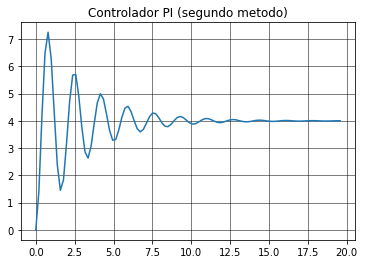

In [6]:
### Control PI metodo 2
# Se establecen los valores Kcr, Pcr
Kcr = 210
Pcr = 1.305

# Se encuentran los valores K_p, tau_i, tau_d
Kp = 0.45*Kcr
tau_i = Pcr/1.2
tau_d = 0
print(Kp, tau_i, tau_d)

# Se encuentran los valores para K_i y K_d
Ki = Kp/tau_i
Kd = Kp*tau_d
print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]
#print(num)
#print(den)

sysPI = ctr.TransferFunction(num,den)
#T = np.linspace(0,1.305,1000)
t, c_t = ctr.step_response(sysPI)

plt.plot(t,c_t)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Controlador PI (segundo metodo)')
plt.show()

126.0 0.6525 0.163125
126.0 0 20.553749999999997


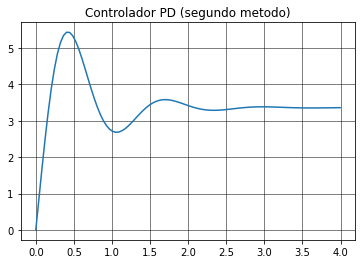

In [7]:
### Método 2 PD

# Se establecen los valores Kcr, 
Kcr = 210
Pcr = 1.305

# Se encuentran los valores K_p, tau_i, tau_d
Kp = 0.6*Kcr
tau_i = 0.5*Pcr
tau_d = 0.125*Pcr
print(Kp, tau_i, tau_d)

# Se encuentran los valores para K_i y K_d
Ki = 0#Kp/tau_i
Kd = Kp*tau_d
print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]
#print(num)
#print(den)

sysPD = ctr.TransferFunction(num,den)
#T = np.linspace(0,1.305,1000)
t, c_t = ctr.step_response(sysPD)

plt.plot(t,c_t)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Controlador PD (segundo metodo)')
plt.show()

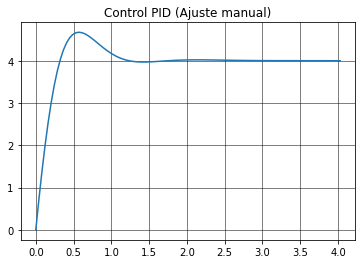

In [64]:
### Método 2 PID
# Aplicacion del PID con cuchareo

# Se establecen los valores para K_i y K_d
Kp = 70
Ki = 80
Kd = 18
#print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]

sys2 = ctr.TransferFunction(num,den)
#T = np.linspace(0,1.305,1000)
t, c_t = ctr.step_response(sys2)

plt.plot(t,c_t)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Control PID (Ajuste manual)')
plt.show()

In [34]:
### Seguimiento de una senial senoidal

# se establece la funcion de transferencia como anteriormente
# Se establecen los valores para K_i y K_d
Kp = 70
Ki = 80
Kd = 18
#print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]

sys_tf = ctr.TransferFunction(num,den)

# se obtienen las variables de estado
sys_ss = ctr.tf2ss(sys_tf)
A = sys_ss.A
B = sys_ss.B
C = sys_ss.C
#print(A)

# Se define el tiempo en el que el sistema funcionará
delta_t = 0.1
t_0 = 0.
t_end = 10.
n = int((t_end - t_0)/delta_t)+1

t = np.linspace(t_0, t_end, n)

# Matriz con las variables de estado deseadas
x1 = np.sin(t)
x2 = np.zeros(n)#np.cos(t)
x3 = np.zeros(n)#-x1#np.zeros(n)
x4 = np.zeros(n)#-x2


x = np.matrix([x1, x2, x3, x4])
#print(x[:,0])

# Se aplica el metodo de euler de forma iterativa
for k in range(0,n):
    if k == 0:
        y = np.zeros(4)
        yk_1 = y
        print(yk_1)
    else:
        yk = np.add(yk_1, (A.dot(x[:,k])))
        yk_1 = yk
        
    print(yk)
    print(' ')


[0. 0. 0. 0.]
[[1309.99935577 1309.99935577 1309.99935577 1309.99935577]
 [  18.10337658   18.10337658   18.10337658   18.10337658]
 [  -6.35521261   -6.35521261   -6.35521261   -6.35521261]
 [ -18.10337658  -18.10337658  -18.10337658  -18.10337658]]
 
[[-0.89850075 -0.89850075 -0.89850075 -0.89850075]
 [ 0.09983342  0.09983342  0.09983342  0.09983342]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
 
[[-2.68652473 -2.68652473 -2.68652473 -2.68652473]
 [ 0.29850275  0.29850275  0.29850275  0.29850275]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
 
[[-5.34620659 -5.34620659 -5.34620659 -5.34620659]
 [ 0.59402295  0.59402295  0.59402295  0.59402295]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
 
[[-8.85097167 -8.85097167 -8.85097167 -8.85097167]
 [ 0.9834413   0.9834413   0.9834413   0.9834413 ]
 [ 0.          0.       

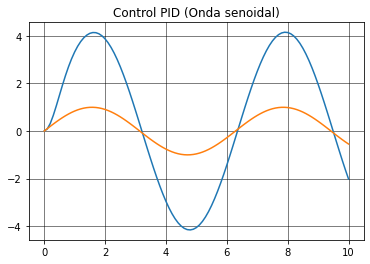

In [49]:
### Seguimiento de onda senoidal aplicando librerías
# se establece la funcion de transferencia como anteriormente
# Se establecen los valores para K_i y K_d
Kp = 70
Ki = 80
Kd = 18
#print(Kp, Ki, Kd)

# Función de transferencia del sistema
num = [0., Kd, Kp+4*Kd, 4*Kp+Ki, 4*Ki]
den = [1., 9., 26+Kd, 24+Kp, Ki]

sys_tf = ctr.TransferFunction(num,den)

# Se define el tiempo en el que el sistema funcionará
delta_t = 0.1
t_0 = 0.
t_end = 10.
n = int((t_end - t_0)/delta_t)+1

t = np.linspace(t_0, t_end, n)

# Entrada deseada
U = np.sin(t)

T, yout, xout = ctr.forced_response(sys_tf,t,U)


plt.plot(T,yout)
plt.plot(T,U)
plt.grid(color='k', linestyle='-', linewidth=0.5)
plt.title('Control PID (Onda senoidal)')
plt.show()